# Lucas-Kanade Optical Flow Estimation

## By: Mustafa Yildirim

Implementing the function myFlow, which takes as input two images, the window length for computing the flow around a point, and a threshold (τ). 

The function returns u (horizontal component of the optical flow), v (vertical component of the optical flow), and a binary map.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import kornia
import cv2

Loading the images and converting them to greyscale

Sphere:

Image shape: (200, 200, 3)


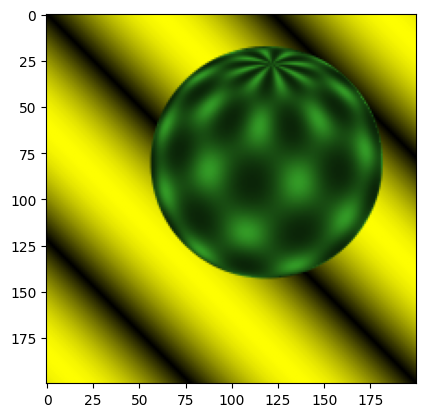

Grey image shape: (200, 200)


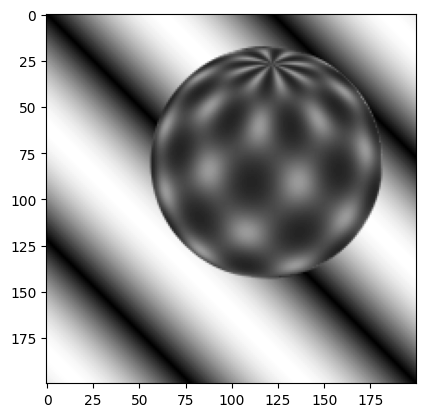

In [2]:
sphere_0_np = plt.imread('Sequences/sphere/sphere_0.png')
print("Image shape:", sphere_0_np.shape)

plt.imshow(sphere_0_np)
plt.show()


sphere_0_grey= cv2.cvtColor(sphere_0_np,cv2.COLOR_BGR2GRAY)
print("Grey image shape:",sphere_0_grey.shape)

plt.imshow(sphere_0_grey, cmap='gray')
plt.show()

Image shape: (200, 200, 3)


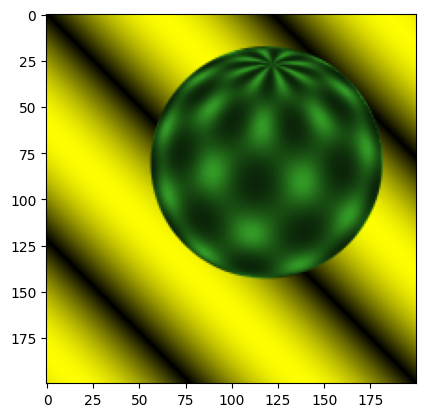

Grey image shape: (200, 200)


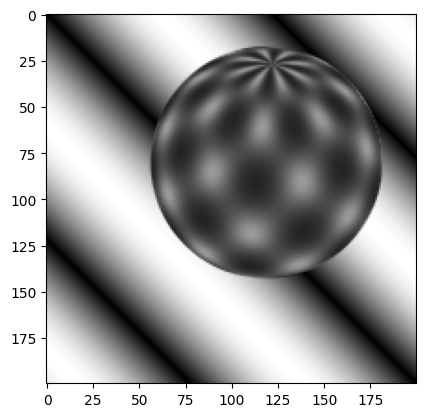

In [3]:
sphere_1_np = plt.imread('Sequences/sphere/sphere_1.png')
print("Image shape:", sphere_1_np.shape)

plt.imshow(sphere_1_np)
plt.show()


sphere_1_grey= cv2.cvtColor(sphere_1_np,cv2.COLOR_BGR2GRAY)
print("Grey image shape:",sphere_1_grey.shape)

plt.imshow(sphere_1_grey, cmap='gray')
plt.show()

Bt (Already Greyscale):

Image shape: (256, 256)


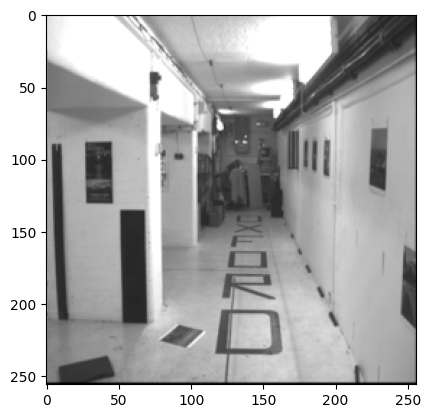

In [4]:
bt_0_np = plt.imread('Sequences/corridor/bt_0.png')
print("Image shape:", bt_0_np.shape)

plt.imshow(bt_0_np, cmap='gray')
plt.show()

Image shape: (256, 256)


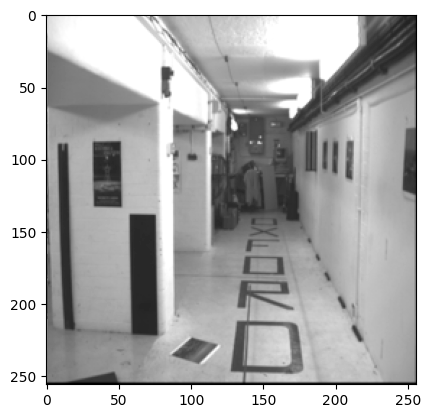

In [5]:
bt_1_np = plt.imread('Sequences/corridor/bt_1.png')
print("Image shape:", bt_1_np.shape)

plt.imshow(bt_1_np, cmap='gray')
plt.show()

Synth (Already Greyscale):

Image shape: (128, 128)


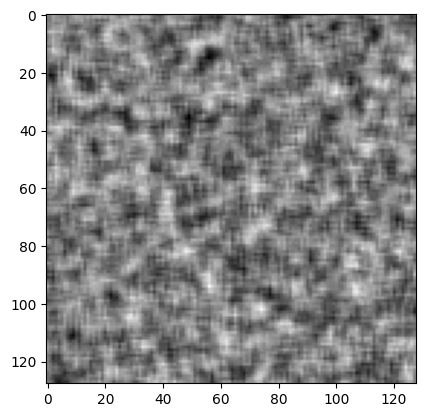

In [6]:
synth_0_np = plt.imread('Sequences/synth/synth_0.png')
print("Image shape:", synth_0_np.shape)

plt.imshow(synth_0_np, cmap='gray')
plt.show()

Image shape: (128, 128)


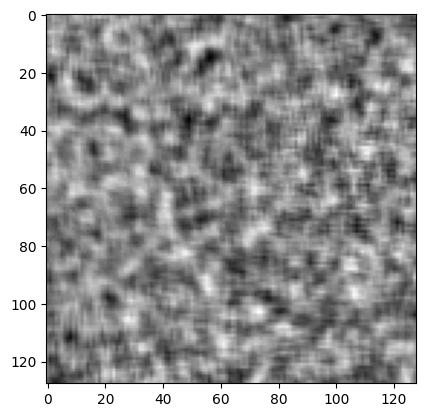

In [7]:
synth_1_np = plt.imread('Sequences/synth/synth_1.png')
print("Image shape:", synth_1_np.shape)

plt.imshow(synth_1_np, cmap='gray')
plt.show()

myFlow function

In [8]:
def myFlow(img1, img2, window_length, T):
    
    # Initializing flow vectors and binary map
    u = np.zeros(img1.shape)
    v = np.zeros(img1.shape)
    binary_map = np.zeros(img1.shape, dtype=bool)
    
    # Computing the spatial derivatives
    filter = (1/12) * np.array([-1, 8, 0, -8, 1])
    Ix = cv2.filter2D(img1, -1, filter.reshape(1, -1))
    Iy = cv2.filter2D(img1, -1, filter.reshape(-1, 1))
    
    # Computing the temporal derivative
    img1_tensor = torch.tensor(img1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    img2_tensor = torch.tensor(img2, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    blurred_img1 = kornia.filters.gaussian_blur2d(img1_tensor, (3, 3), (1, 1))
    blurred_img2 = kornia.filters.gaussian_blur2d(img2_tensor, (3, 3), (1, 1))
    It = blurred_img2.squeeze().numpy() - blurred_img1.squeeze().numpy()
   
    # Computing the local gradients over a window centred around each pixel
    for y in range((window_length // 2), img1.shape[0] - (window_length // 2)):
        for x in range((window_length // 2), img1.shape[1] - (window_length // 2)):

            Ix_w = Ix[y - (window_length // 2) : y + (window_length // 2) + 1, x - (window_length // 2) : x + (window_length // 2) + 1].flatten()
            Iy_w = Iy[y - (window_length // 2) : y + (window_length // 2) + 1, x - (window_length // 2) : x + (window_length // 2) + 1].flatten()
            It_w = It[y - (window_length // 2) : y + (window_length // 2) + 1, x - (window_length // 2) : x + (window_length // 2) + 1].flatten()

            IxIx = np.sum(Ix_w * Ix_w)
            IyIy = np.sum(Iy_w * Iy_w)
            IxIy = np.sum(Ix_w * Iy_w)
            IxIt = np.sum(Ix_w * It_w)
            IyIt = np.sum(Iy_w * It_w)
            
            ATA = np.array([[IxIx, IxIy], [IxIy, IyIy]])
            ATb = np.array([IxIt, IyIt])
            
            # Computing the optical flow if the smallest eigenvalue is greater than threshold T
            if np.min(np.linalg.eigvals(ATA)) > T:
                v_vector = np.linalg.pinv(ATA) @ ATb
                u[y, x], v[y, x] = v_vector
                binary_map[y, x] = True
    
    
    return u, v, binary_map

flowToColor function

In [9]:
'''
python by:  youngjung uh, Clova ML, Naver
contact:    youngjung.uh@navercorp.com
date:       17 Dec 2018

-------------------------------------------------------------------
----- below comment came from the original (flowToColor.m) --------
-------------------------------------------------------------------
flowToColor(flow, maxFlow) flowToColor color codes flow field, normalize
based on specified value,

flowToColor(flow) flowToColor color codes flow field, normalize
based on maximum flow present otherwise

According to the c++ source code of Daniel Scharstein
Contact: schar@middlebury.edu

Author: Deqing Sun, Department of Computer Science, Brown University
Contact: dqsun@cs.brown.edu
$Date: 2007-10-31 18:33:30 (Wed, 31 Oct 2006) $

Copyright 2007, Deqing Sun.

                        All Rights Reserved

Permission to use, copy, modify, and distribute this software and its
documentation for any purpose other than its incorporation into a
commercial product is hereby granted without fee, provided that the
above copyright notice appear in all copies and that both that
copyright notice and this permission notice appear in supporting
documentation, and that the name of the author and Brown University not be used in
advertising or publicity pertaining to distribution of the software
without specific, written prior permission.

THE AUTHOR AND BROWN UNIVERSITY DISCLAIM ALL WARRANTIES WITH REGARD TO THIS SOFTWARE,
INCLUDING ALL IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY
PARTICULAR PURPOSE.  IN NO EVENT SHALL THE AUTHOR OR BROWN UNIVERSITY BE LIABLE FOR
ANY SPECIAL, INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES
WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN
ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF
OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.
'''

import numpy as np

def flowToColor(flow, maxflow=None, verbose=False):
    '''
    args
        flow (numpy array) height x width x 2
    return
        img_color (numpy array) height x width x 3
    '''

    UNKNOWN_FLOW_THRESH = 5e2
    eps = 1e-6

    height, widht, nBands = flow.shape

    if nBands != 2:
        exit('flowToColor: image must have two bands')

    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999
    maxv = -999

    minu = 999
    minv = 999
    maxrad = -1

    # fix unknown flow
    idxUnknown = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknown] = 0
    v[idxUnknown] = 0

    maxu = max(maxu, u.max())
    minu = min(minu, u.min())

    maxv = max(maxv, v.max())
    minv = min(minv, v.min())

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(maxrad, rad.max())

    if verbose:
        print('max flow: %.4f flow range: u = %.3f .. %.3f; v = %.3f .. %.3f\n' %
              (maxrad, minu, maxu, minv, maxv))

    if maxflow is not None:
        if maxflow > 0:
            maxrad = maxflow

    u = u / (maxrad + eps)
    v = v / (maxrad + eps)

    img = computeColor(u, v)

    # unknown flow
    # IDX = repmat(idxUnknown, [1, 1, 3])
    img[idxUnknown] = 0

    return img

def computeColor(u, v, cast_uint8=True):
    '''
    args
        u (numpy array) height x width
        v (numpy array) height x width
        cast_uint8 (bool) set False to have image range 0-1 (np.float32)
    return
        img_color (numpy array) height x width x 3
    '''

    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = makeColorwheel()
    ncols = colorwheel.shape[0]

    rad = np.sqrt(u ** 2 + v ** 2)

    a = np.arctan2(-v, -u)/np.pi

    fk = (a + 1) / 2 * (ncols - 1)  # -1~1 maped to 1~ncols

    k0 = np.floor(fk).astype(int)  # 1, 2, ..., ncols

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1

    f = fk - k0

    height, width = u.shape
    img = np.zeros((height, width, 3), np.float32)
    nrows = colorwheel.shape[1]
    for i in range(nrows):
        tmp = colorwheel[:, i]
        col0 = tmp[k0.reshape(-1)] / 255
        col1 = tmp[k1.reshape(-1)] / 255
        col = col0.reshape(height, width) * (1 - f) + \
              col1.reshape(height, width) * f

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])  # increase saturation with radius

        col[np.logical_not(idx)] *= 0.75  # out of range

        img[:, :, i] = col * (1 - nanIdx)

    if cast_uint8:
        img = np.floor(img * 255).astype(np.uint8)
    return img


def makeColorwheel():
    '''
    color encoding scheme
    adapted from the color circle idea described at
    http://members.shaw.ca/quadibloc/other/colint.htm
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros((ncols, 3))  # r g b

    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.array(range(RY))/RY)
    col = col+RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.array(range(YG))/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.array(range(GC))/GC)
    col = col+GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.array(range(CB))/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.array(range(BM))/BM)
    col = col+BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.array(range(MR))/MR)
    colorwheel[col:col+MR, 0] = 255

    return colorwheel


# flowToColor(np.zeros((224,224,2)))

Running the myFlow function

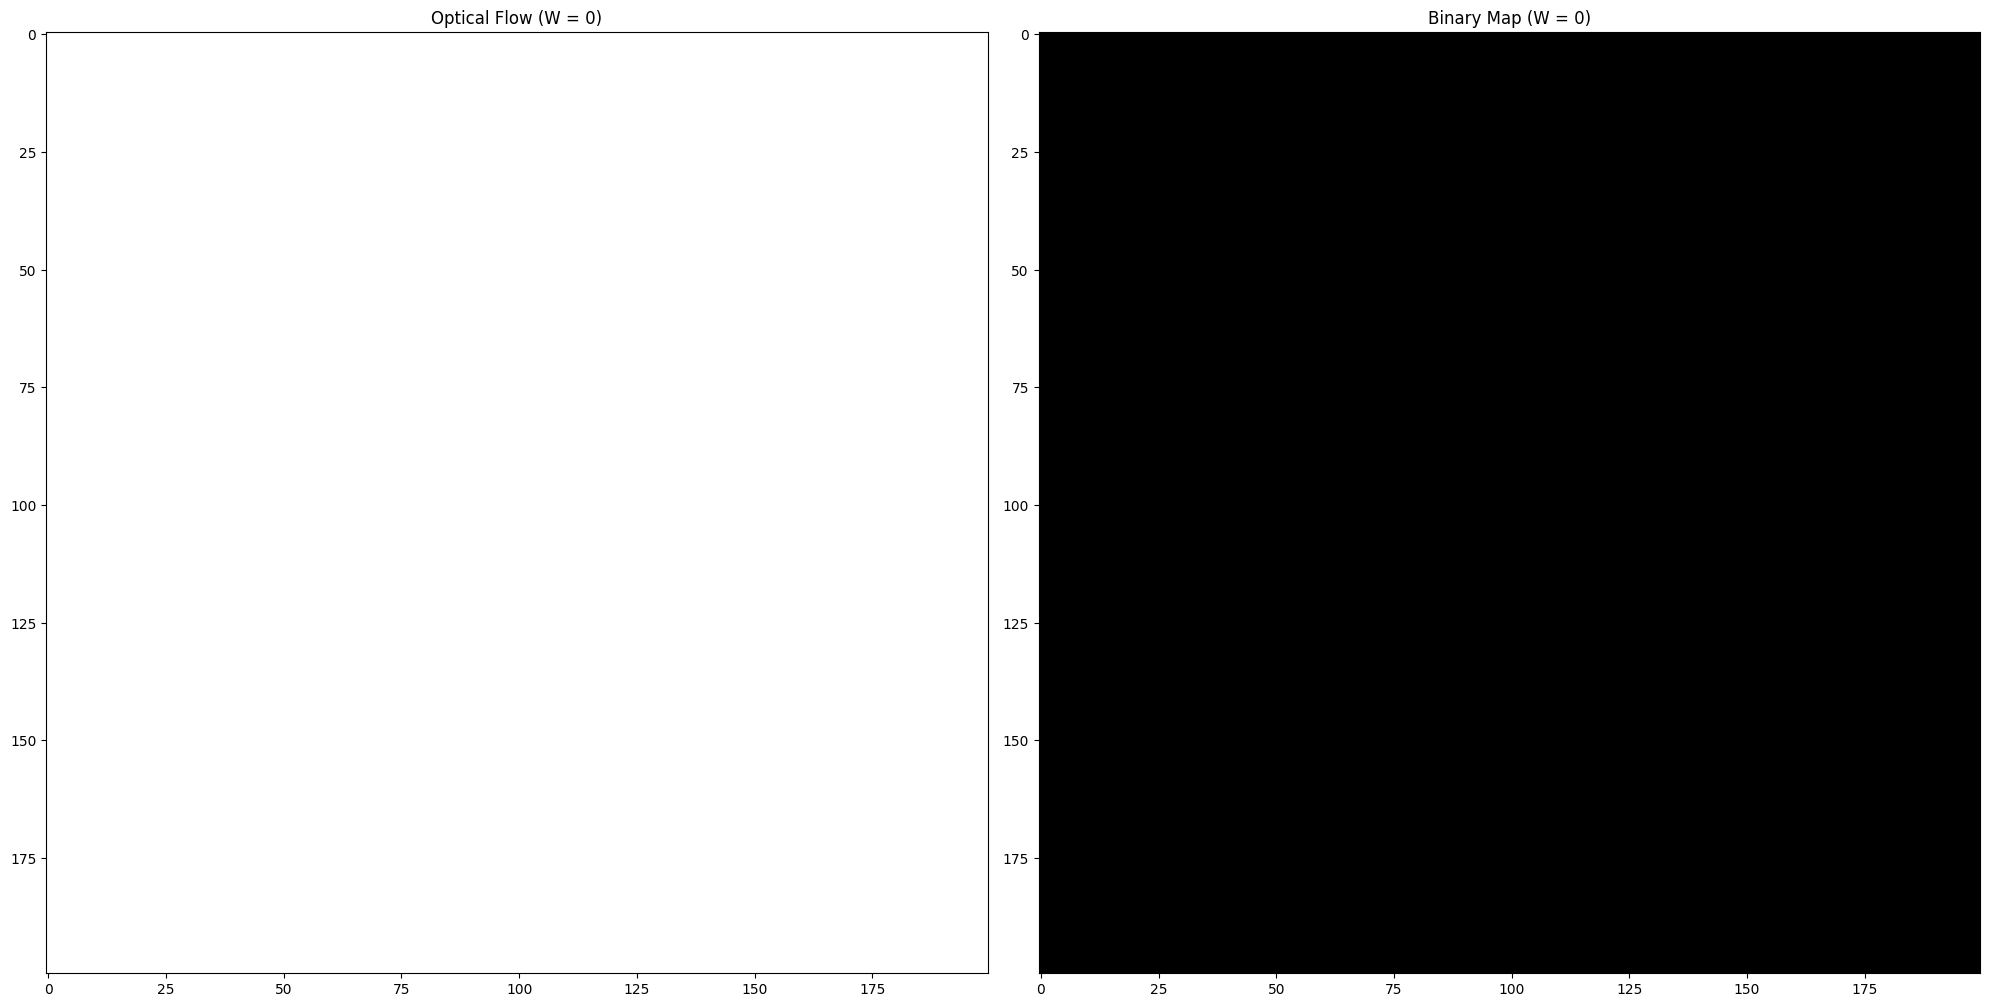

In [10]:
window_length = 0
T = 0.01

# Computing Optical Flow
u_sp, v_sp, binary_map_sp = myFlow(sphere_0_grey, sphere_1_grey, window_length, T)

# Creating the flow representation
flow_sphere = np.zeros((sphere_0_grey.shape[0], sphere_0_grey.shape[1], 2))
flow_sphere[:, :, 0] = u_sp
flow_sphere[:, :, 1] = v_sp

flow_sphere_img = flowToColor(flow_sphere)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Optical Flow Visualization
axes[0].imshow(flow_sphere_img)
axes[0].set_title(f"Optical Flow (W = {window_length})")

# Binary Map Visualization
axes[1].imshow(binary_map_sp, cmap="gray")
axes[1].set_title(f"Binary Map (W = {window_length})")

plt.tight_layout()
plt.show()

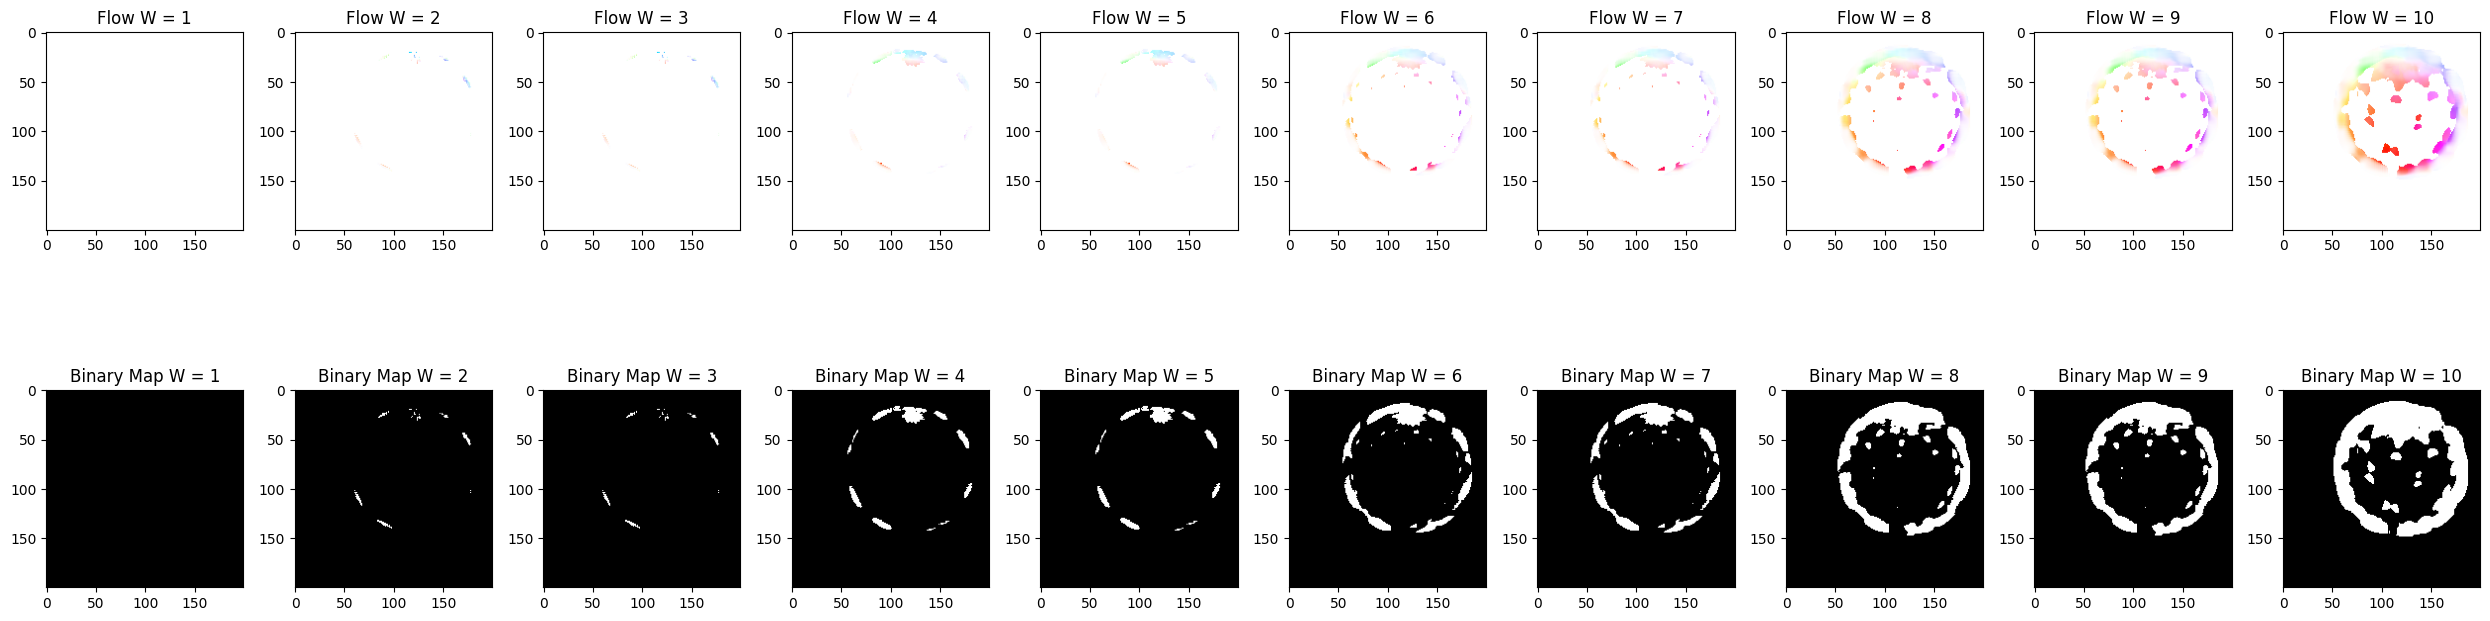

In [11]:
T = 0.01

fig, axes = plt.subplots(2, 10, figsize=(25, 8))

for idx, window_length in enumerate(range(1, 11)):
    
    # Computing Optical Flow
    u_sp, v_sp, binary_map_sp = myFlow(sphere_0_grey, sphere_1_grey, window_length, T)

    # Creating the flow representation
    flow_sphere = np.zeros((sphere_0_grey.shape[0], sphere_0_grey.shape[1], 2))
    flow_sphere[:, :, 0] = u_sp
    flow_sphere[:, :, 1] = v_sp

    flow_sphere_img = flowToColor(flow_sphere)

    # Optical Flow Visualization
    axes[0, idx].imshow(flow_sphere_img)
    axes[0, idx].set_title(f"Flow W = {window_length}")

    # Binary Map Visualization
    axes[1, idx].imshow(binary_map_sp, cmap="gray")
    axes[1, idx].set_title(f"Binary Map W = {window_length}")

plt.tight_layout()
plt.show()

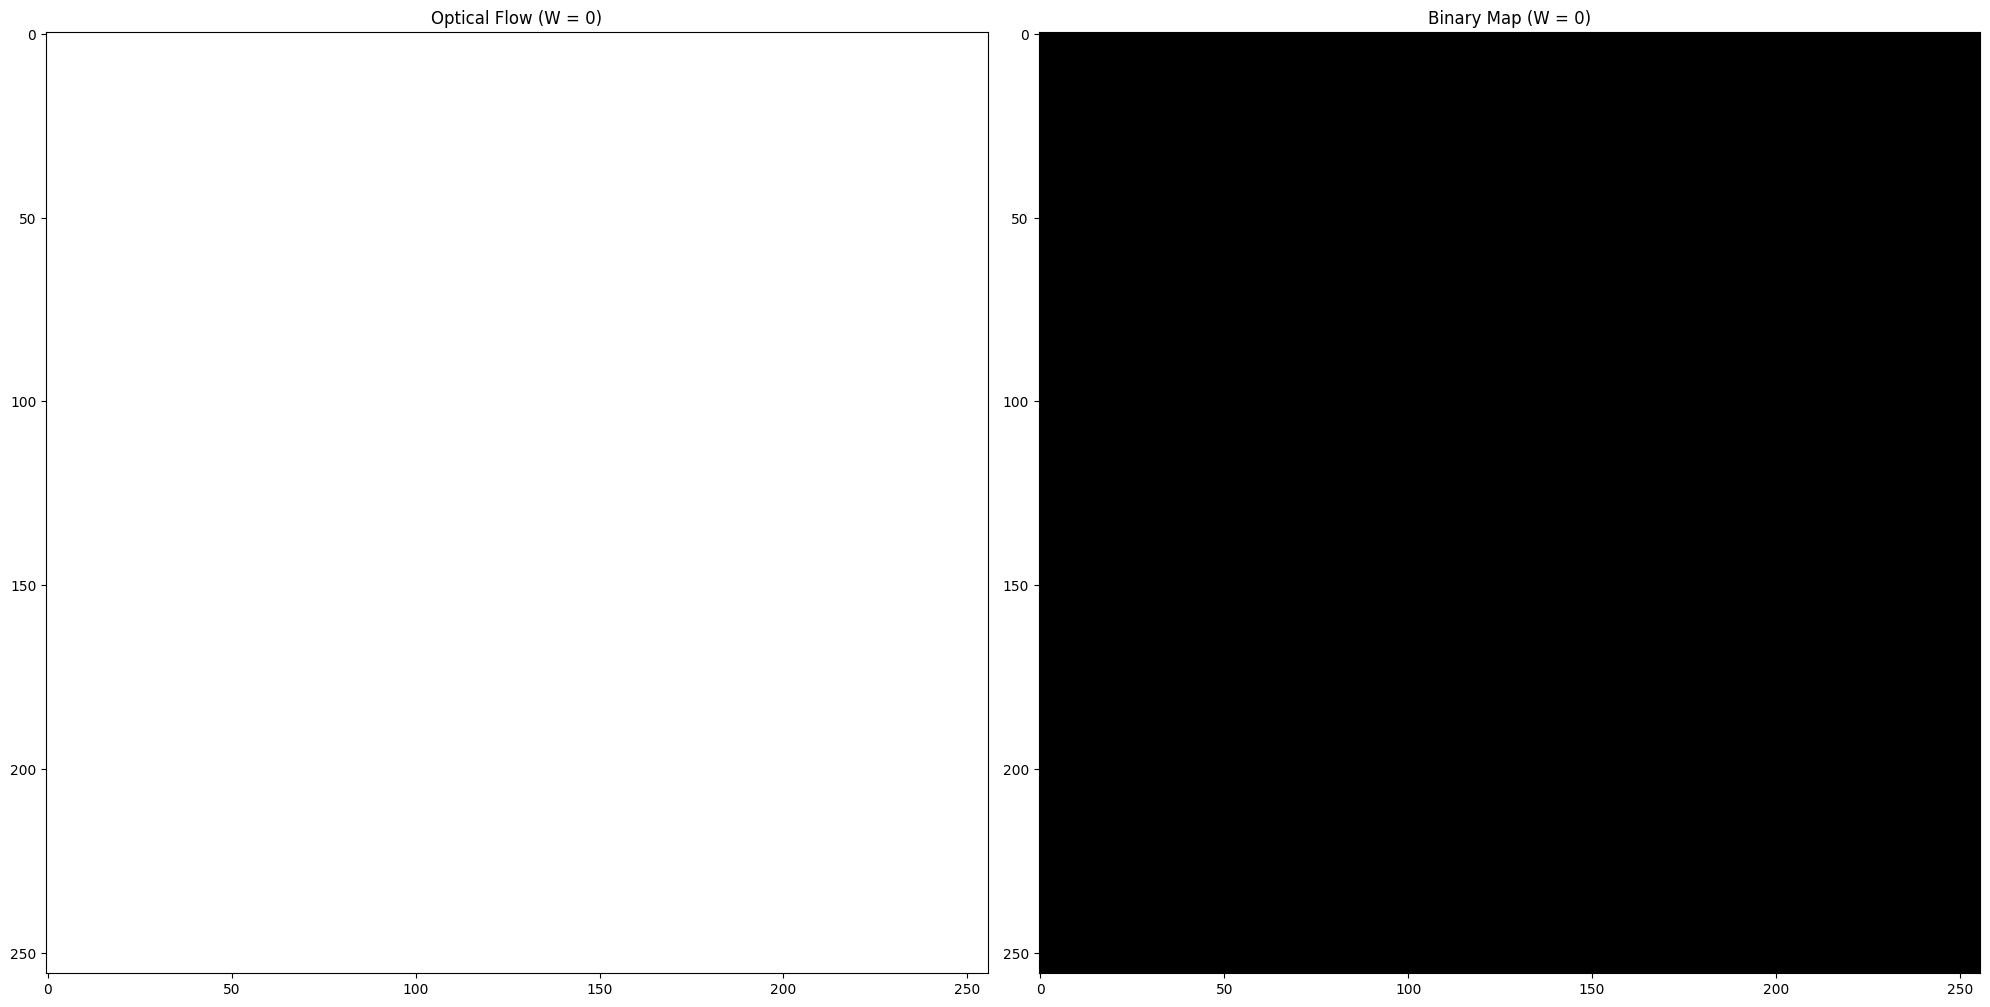

In [12]:
window_length = 0
T = 0.01

# Computing Optical Flow
u_bt, v_bt, binary_map_bt = myFlow(bt_0_np, bt_1_np, window_length, T)

# Creating the flow representation
flow_bt = np.zeros((bt_0_np.shape[0], bt_0_np.shape[1], 2))
flow_bt[:, :, 0] = u_bt
flow_bt[:, :, 1] = v_bt

flow_bt_img = flowToColor(flow_bt)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Optical Flow Visualization
axes[0].imshow(flow_bt_img)
axes[0].set_title(f"Optical Flow (W = {window_length})")

# Binary Map Visualization
axes[1].imshow(binary_map_bt, cmap="gray")
axes[1].set_title(f"Binary Map (W = {window_length})")

plt.tight_layout()
plt.show()

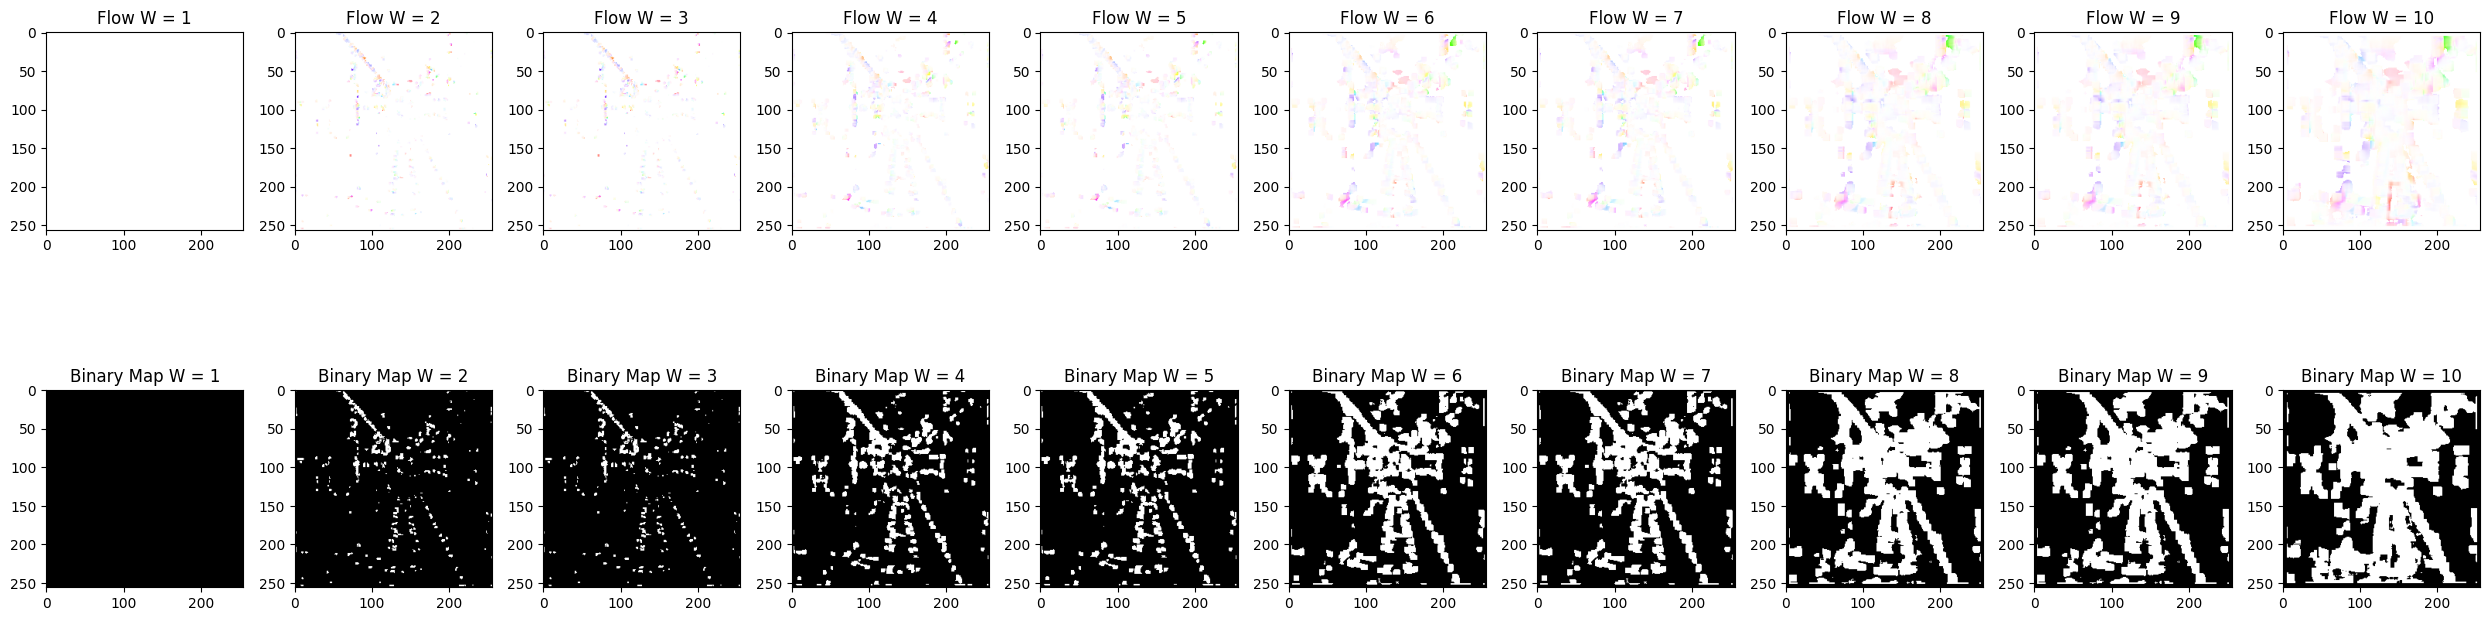

In [13]:
T = 0.01

fig, axes = plt.subplots(2, 10, figsize=(25, 8))

for idx, window_length in enumerate(range(1, 11)):
    
    # Computing Optical Flow
    u_bt, v_bt, binary_map_bt = myFlow(bt_0_np, bt_1_np, window_length, T)

    # Creating the flow representation
    flow_bt = np.zeros((bt_0_np.shape[0], bt_0_np.shape[1], 2))
    flow_bt[:, :, 0] = u_bt
    flow_bt[:, :, 1] = v_bt

    flow_bt_img = flowToColor(flow_bt)

    # Optical Flow Visualization
    axes[0, idx].imshow(flow_bt_img)
    axes[0, idx].set_title(f"Flow W = {window_length}")

    # Binary Map Visualization
    axes[1, idx].imshow(binary_map_bt, cmap="gray")
    axes[1, idx].set_title(f"Binary Map W = {window_length}")

plt.tight_layout()
plt.show()

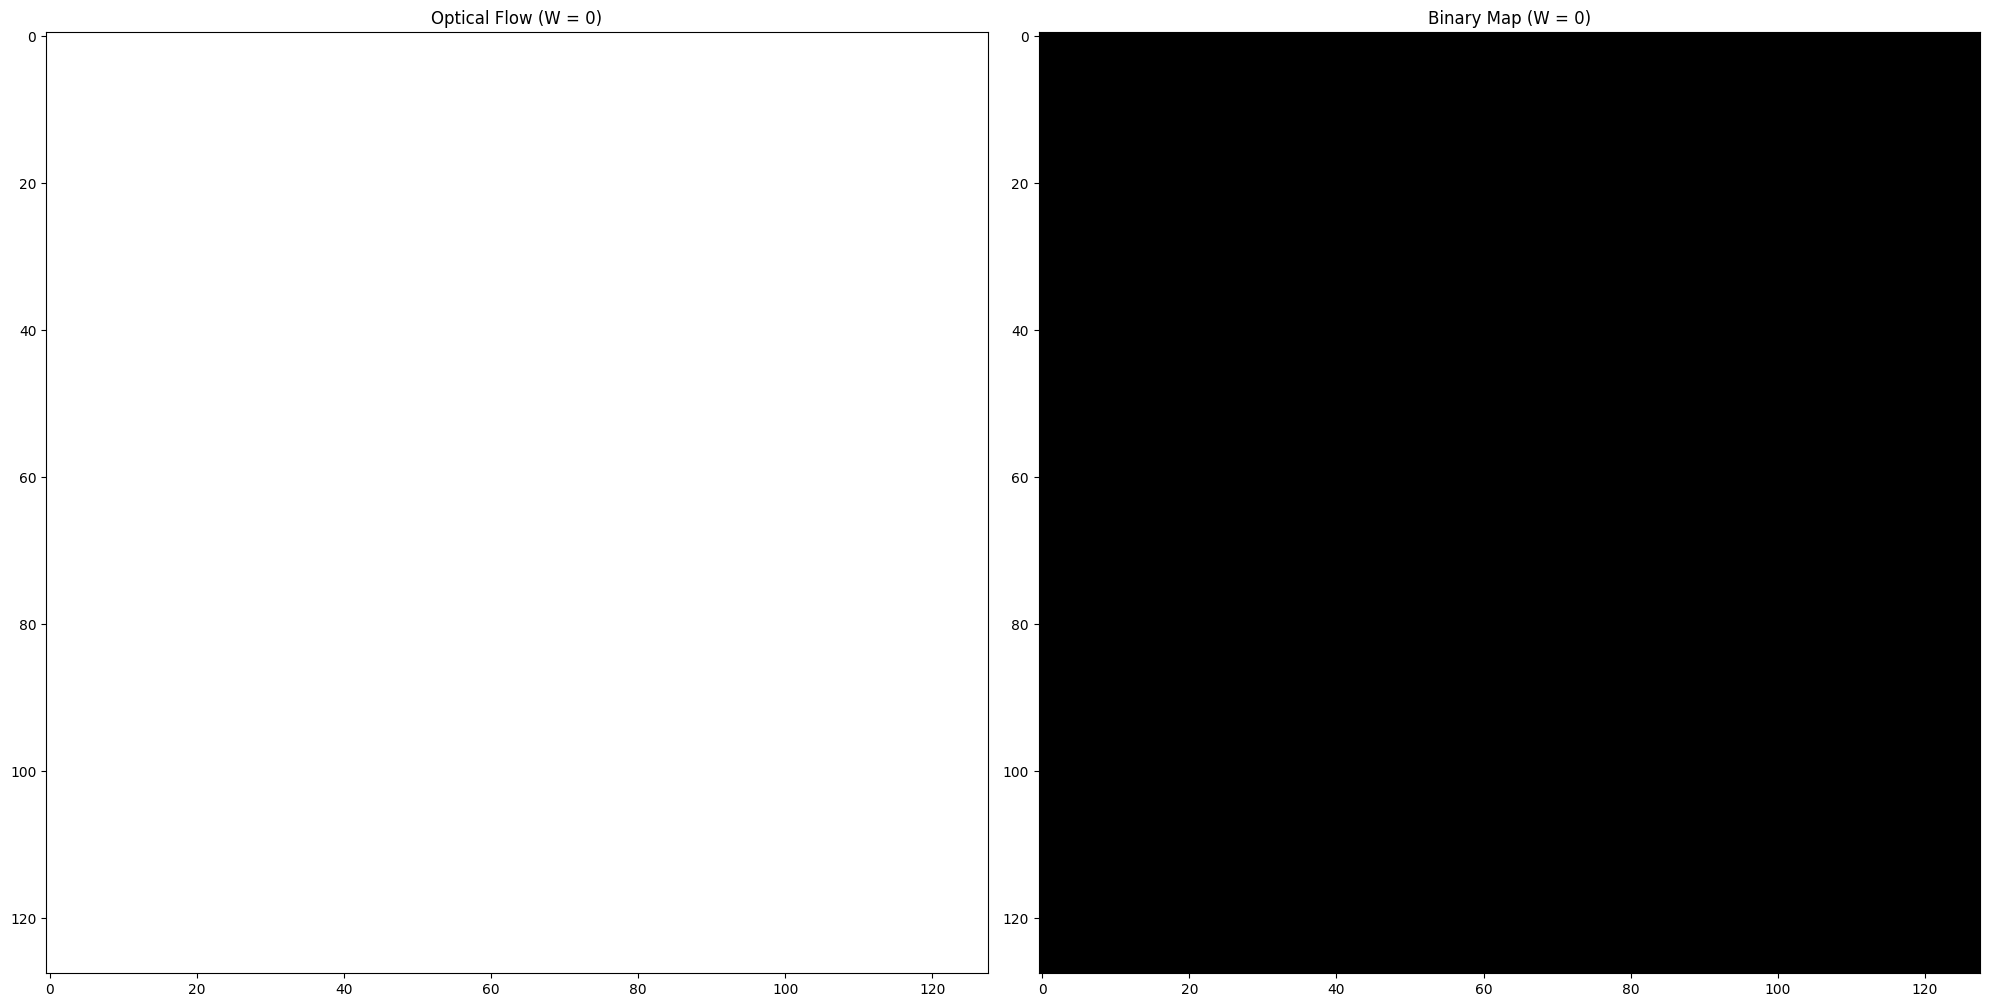

In [14]:
window_length = 0
T = 0.01

# Computing Optical Flow
u_sy, v_sy, binary_map_sy = myFlow(synth_0_np, synth_1_np, window_length, T)

# Creating the flow representation
flow_synth = np.zeros((synth_0_np.shape[0], synth_0_np.shape[1], 2))
flow_synth[:, :, 0] = u_sy
flow_synth[:, :, 1] = v_sy

flow_synth_img = flowToColor(flow_synth)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Optical Flow Visualization
axes[0].imshow(flow_synth_img)
axes[0].set_title(f"Optical Flow (W = {window_length})")

# Binary Map Visualization
axes[1].imshow(binary_map_sy, cmap="gray")
axes[1].set_title(f"Binary Map (W = {window_length})")

plt.tight_layout()
plt.show()

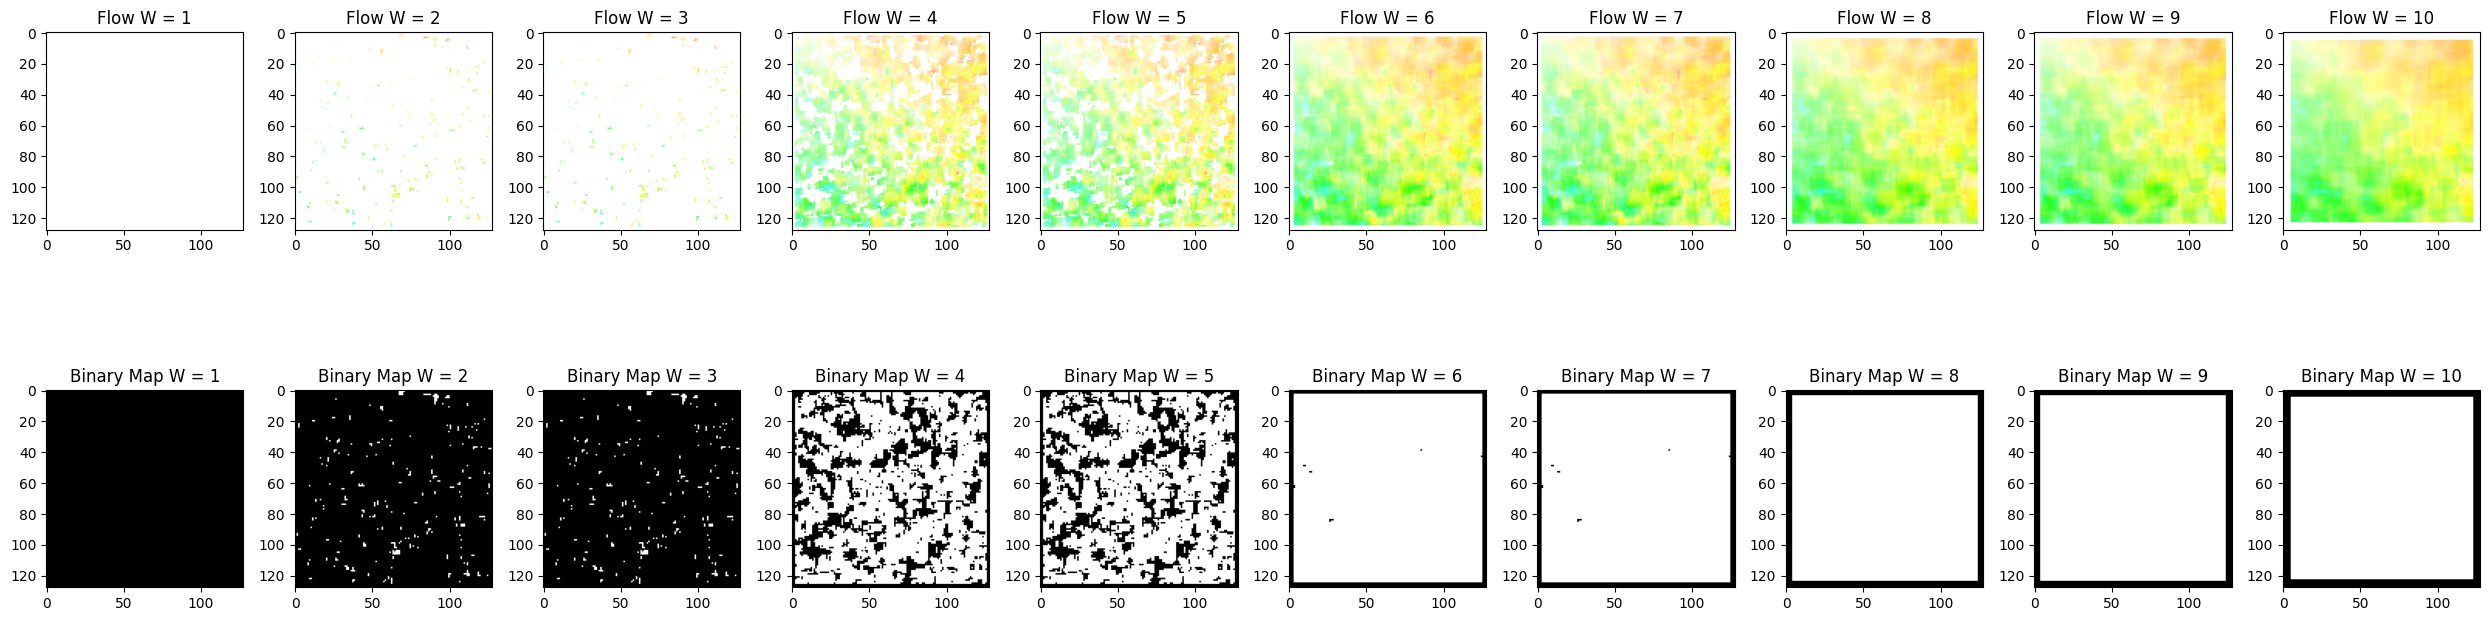

In [15]:
T = 0.01

fig, axes = plt.subplots(2, 10, figsize=(25, 8))

for idx, window_length in enumerate(range(1, 11)):
    
    # Computing Optical Flow
    u_sy, v_sy, binary_map_sy = myFlow(synth_0_np, synth_1_np, window_length, T)

    # Creating the flow representation
    flow_synth = np.zeros((synth_0_np.shape[0], synth_0_np.shape[1], 2))
    flow_synth[:, :, 0] = u_sy
    flow_synth[:, :, 1] = v_sy

    flow_synth_img = flowToColor(flow_synth)

    # Optical Flow Visualization
    axes[0, idx].imshow(flow_synth_img)
    axes[0, idx].set_title(f"Flow W = {window_length}")

    # Binary Map Visualization
    axes[1, idx].imshow(binary_map_sy, cmap="gray")
    axes[1, idx].set_title(f"Binary Map W = {window_length}")

plt.tight_layout()
plt.show()

**Explanation of what effect the window length parameter has on the result:**

The window length determines how much of the surrounding area is considered when detecting motion between frames.

If the window length is smaller, it captures smaller movements but can pick up more noise. 

If the window length is larger, it captures bigger movements but can miss small details.